In [144]:
from pathlib import Path

project_dir = Path('.').absolute().parent
project_dir

PosixPath('/home/daniel/Documents/github/mcx-lab/rl-baselines3-zoo')

In [145]:
import gym 

env = gym.make("A1GymEnv-v0")
foot_names = env.robot.GetFootNames()

Init CPG gait=walk, duty_factor=0.75, period=0.6666666666666666
argv[0]=


/home/daniel/anaconda3/envs/rl-baselines-zoo-cu113/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


# Inspect logged inputs / outputs

Logs generated with `scripts/enjoy_with_logging.py`

In [146]:
import numpy as np
import pickle 
import json

def load_robot_states(stats_dir):
    base_position = np.load(stats_dir / 'base_pos.npy')
    base_velocity = np.load(stats_dir / 'base_vel.npy')
    motor_position = np.load(stats_dir / 'motor_position.npy')
    motor_velocity = np.load(stats_dir / 'motor_velocity.npy')
    ref_displacement = np.load(stats_dir / 'reference_displacement.npy')
    act_displacement = np.load(stats_dir / 'actual_displacement.npy')
    ref_foot_contacts = np.load(stats_dir / 'reference_foot_contact.npy')
    act_foot_contacts = np.load(stats_dir / 'actual_foot_contact.npy')
    nn_observations = np.load(stats_dir / 'nn_observations.npy')

    reward_component_values = np.load(stats_dir / 'reward_components.npy')
    with open(stats_dir / 'reward_component_names.json', 'r') as file:
        reward_component_names = json.load(file)
    print(nn_observations.shape)
    nn_actions = np.load(stats_dir / 'nn_actions.npy')
    time = np.load(stats_dir / 'time.npy')
    
    return {
        'time': time, 
        'base_pos': base_position,
        'base_vel': base_velocity,
        'motor_pos': motor_position, 
        'motor_vel': motor_velocity, 
        'ref_displacement': ref_displacement,
        'act_displacement': act_displacement,
        'ref_foot_contacts': ref_foot_contacts, 
        'act_foot_contacts': act_foot_contacts, 
        'nn_obs': nn_observations,
        'nn_act': nn_actions,
        'reward_component_values': reward_component_values,
        'reward_component_names': reward_component_names
    }

def load_normalizer(model_dir):
    with open(model_dir / 'A1GymEnv-v0' / 'vecnormalize.pkl', 'rb') as file:
        normalizer = pickle.load(file)
    return normalizer

In [147]:
model_dir = project_dir / 'logs' / 'ppo' / 'A1GymEnv-v0_38'

import itertools

DEFAULT_GAIT_FREQUENCY = (1.5,)
ALL_GAIT_FREQUENCIES = (1.1, 1.3, 1.5, 1.7, 1.9)
DEFAULT_DUTY_FACTOR = (0.75,)
ALL_DUTY_FACTORS = (0.55, 0.65, 0.75, 0.85)

settings = itertools.chain(
    itertools.product(DEFAULT_GAIT_FREQUENCY, ALL_DUTY_FACTORS),
    itertools.product(ALL_GAIT_FREQUENCIES, DEFAULT_DUTY_FACTOR)
)


stats_dirs = [
    model_dir / 'stats'
    # model_dir / f'walk-gf{gait_freq}-df{duty}' for (gait_freq, duty) in settings
    # model_dir / 'test_var_duty' / f'duty_{duty}' \
    #     for duty in (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85)
]
# stats_dir1 = model_dir / 'experiments' / 'vary_freq' / 'train_1.0Hz_test_1.0Hz_alpha_10.0'
# stats_dir2 = model_dir / 'experiments' / 'vary_freq' / 'train_1.0Hz_test_2.0Hz'

statss = [load_robot_states(sd) for sd in stats_dirs]
normalizer = load_normalizer(model_dir)

(1000, 1, 73)


# Plot Reference / Actual Foot Contacts

[13.  12.5 13.  13. ]


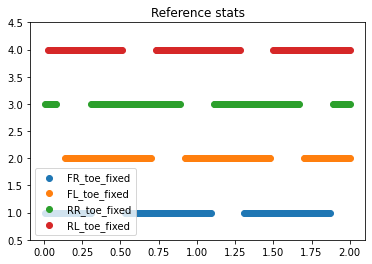

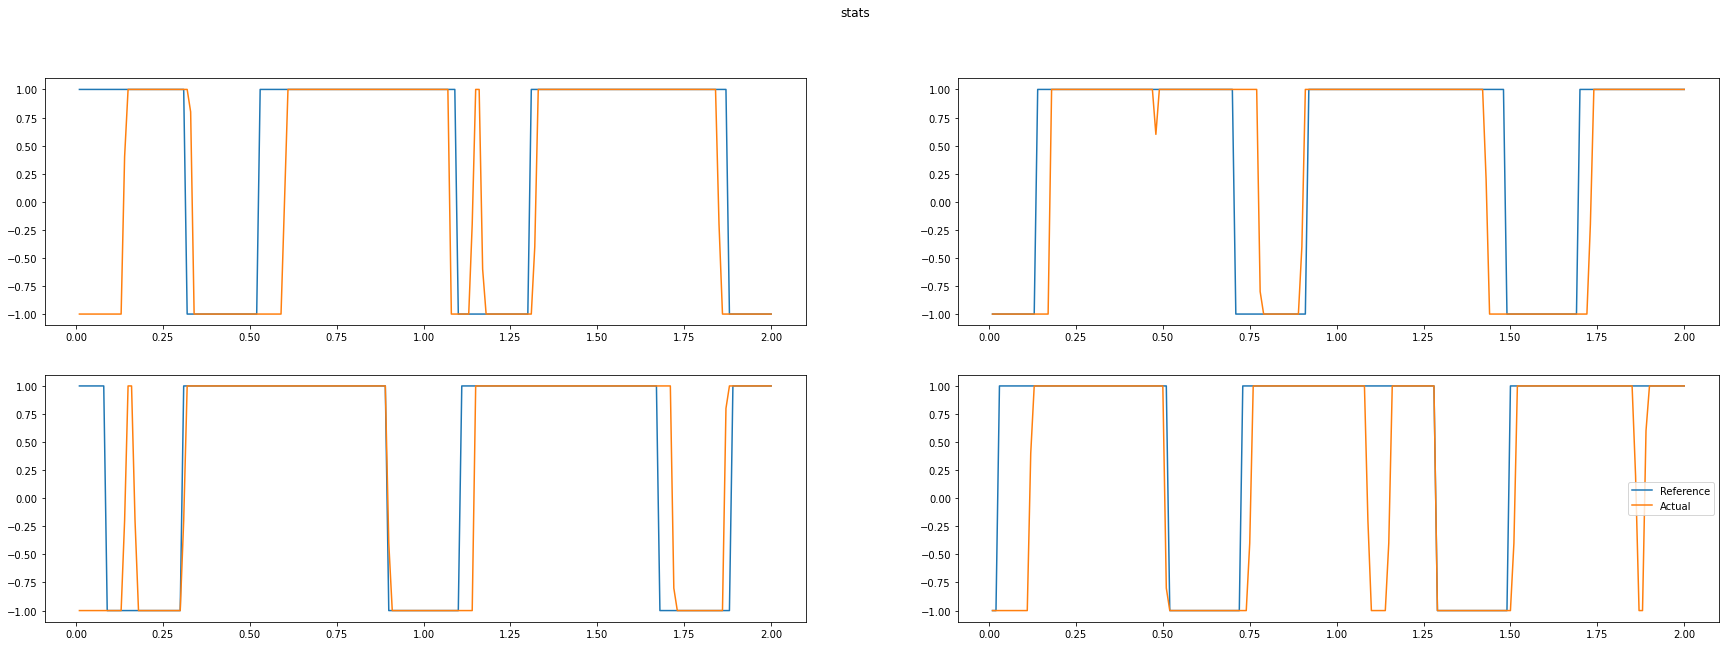

In [148]:
NUM_TIMESTEPS = 200

def plot_foot_contact_sequence(stats, stats_dir):
    import matplotlib.pyplot as plt 
    
    time = stats['time']
    ref_foot_contacts = stats['ref_foot_contacts']
    act_foot_contacts = stats['act_foot_contacts']
    # Every cycle will result in an overall +4 to the absolute difference of consec. terms
    num_cycles = np.sum(np.abs(ref_foot_contacts[:-1] - ref_foot_contacts[1:]), axis=0) / 4
    print(num_cycles)
    
    plt.figure()
    plt.title(f"Reference {stats_dir.name}")
    plt.ylim(0.5, 4.5)
    for i in range(4):    
        plt.scatter(time[:NUM_TIMESTEPS], ref_foot_contacts[:NUM_TIMESTEPS, i] * (i+1), label = foot_names[i])
    plt.legend()

    
    fig, ax = plt.subplots(2,2, figsize=(30,10))
    fig.suptitle(stats_dir.name)
    idxes = [(0,0), (0,1), (1,0), (1,1)]
    for i in range(4):
        # ax[idxes[i]].set_title(f"{foot_names[i]}")
        ax[idxes[i]].plot(time[:NUM_TIMESTEPS], ref_foot_contacts[:NUM_TIMESTEPS, i], label = 'Reference')
        ax[idxes[i]].plot(time[:NUM_TIMESTEPS], act_foot_contacts[:NUM_TIMESTEPS, i], label = 'Actual')
        plt.legend()

for stats, stats_dir in zip(statss, stats_dirs):
    plot_foot_contact_sequence(stats, stats_dir)
    

# Plot Base Position / Velocity vs reference Velocity

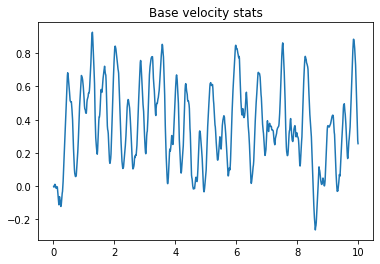

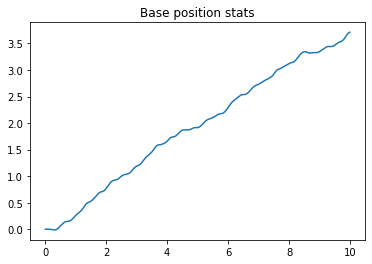

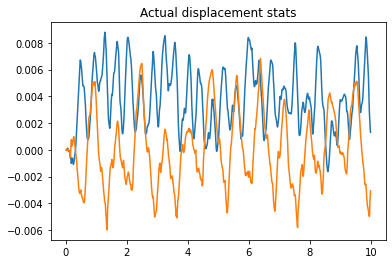

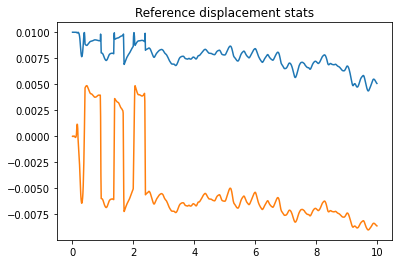

In [149]:
def plot_position_velocity(stats, stats_dir):
    time = stats['time']
    base_vel = stats['base_vel']
    base_pos = stats['base_pos']

    plt.figure()
    plt.title(f"Base velocity {stats_dir.name}")
    plt.plot(time[:-1], base_vel[:-1, 0])
    
    plt.figure()
    plt.title(f"Base position {stats_dir.name}")
    plt.plot(time[:-1], base_pos[:-1, 0])

def plot_actual_reference_displacement(stats, stats_dir):
    time = stats['time']
    ref_disp = stats['ref_displacement']
    act_disp = stats['act_displacement']

    plt.figure()
    plt.title(f"Actual displacement {stats_dir.name}")
    plt.plot(time[:-1], act_disp[:-1])

    plt.figure()
    plt.title(f"Reference displacement {stats_dir.name}")
    plt.plot(time[:-1], ref_disp[:-1])

for stats, stats_dir in zip(statss, stats_dirs):
    plot_position_velocity(stats, stats_dir)
    plot_actual_reference_displacement(stats, stats_dir)

Total reward for distance: 285.09021758803067
Total reward for shake: -158.9603764998438
Total reward for imitation: 5292.15


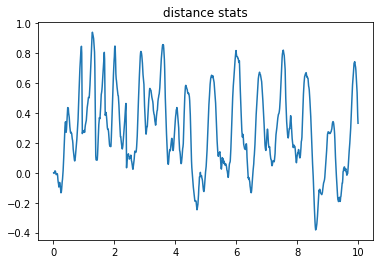

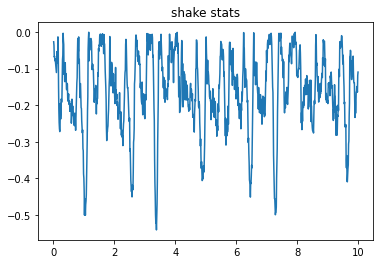

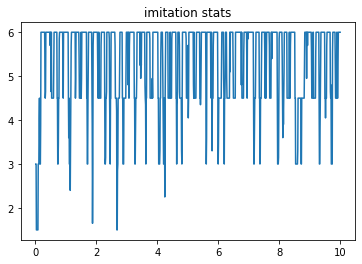

In [153]:
def plot_reward_components(stats, stats_dir):
    time = stats['time']
    reward_components_values = stats['reward_component_values']
    reward_components_names = stats['reward_component_names']

    for i, rew_comp_name in enumerate(reward_components_names):
        plt.figure()
        plt.title(f"{rew_comp_name} {stats_dir.name}")
        plt.plot(time[:-1], reward_components_values[:-1,i])

        print(f"Total reward for {rew_comp_name}: {reward_components_values[:-1,i].sum()}")

for stats, stats_dir in zip(statss, stats_dirs):
    plot_reward_components(stats, stats_dir)